<a href="https://colab.research.google.com/github/NathalieMarko/ds_portfolio/blob/main/Churn_bank_exited.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, log_loss
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier

import sklearn
from catboost import CatBoostClassifier, Pool
from google.colab import files
from sklearn.preprocessing import RobustScaler

In [ ]:
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [ ]:
df_tr = pd.read_csv('train.csv')
df_tt = pd.read_csv('test.csv')


In [ ]:
df_train = df_tr.copy()
df_test = df_tt.copy()

In [ ]:
df_train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [ ]:
def preprocess_data(df):
    df = df.drop_duplicates()
    df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1}).astype('int8')
    df['Geography'] = df['Geography'].map({'France': 0, 'Germany': 1, 'Spain': 2}).astype('int8')
    df['Bal_Tenure'] = df['Balance'] * df['Tenure']
    df['Bal_Age'] = df['Balance'] * df['Age']
    df['Estimsal_Age'] = df['EstimatedSalary'] * df['Age']
    # df['Ten_NumOfProd'] = df['NumOfProducts']*df['Tenure']
    df.drop(['id', 'CustomerId', 'Surname'], inplace=True, axis=1)
    df.fillna(-1, inplace=True)
    scaler = RobustScaler()
    df_scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns)  # Convert back to DataFrame
    return df_scaled


In [ ]:
df_train_pp = preprocess_data(df_train)
df_train_pp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CreditScore      165034 non-null  float64
 1   Geography        165034 non-null  float64
 2   Gender           165034 non-null  float64
 3   Age              165034 non-null  float64
 4   Tenure           165034 non-null  float64
 5   Balance          165034 non-null  float64
 6   NumOfProducts    165034 non-null  float64
 7   HasCrCard        165034 non-null  float64
 8   IsActiveMember   165034 non-null  float64
 9   EstimatedSalary  165034 non-null  float64
 10  Exited           165034 non-null  float64
 11  Bal_Tenure       165034 non-null  float64
 12  Bal_Age          165034 non-null  float64
 13  Estimsal_Age     165034 non-null  float64
dtypes: float64(14)
memory usage: 17.6 MB


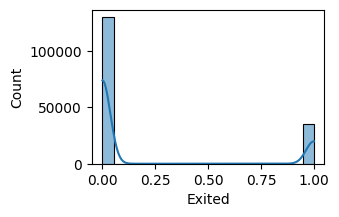

In [ ]:
fig, ax = plt.subplots(figsize=(3, 2))
sns.histplot(df_train_pp['Exited'], kde=True)
plt.show()

In [ ]:
from imblearn.over_sampling import RandomOverSampler

y = df_train_pp['Exited']
X = df_train_pp.drop('Exited', axis=1)

ros = RandomOverSampler(sampling_strategy=1)
X_res_over, y_res_over = ros.fit_resample(X, y)
X_res_over.shape, y_res_over.shape, y.shape, X.shape

((260226, 13), (260226,), (165034,), (165034, 13))

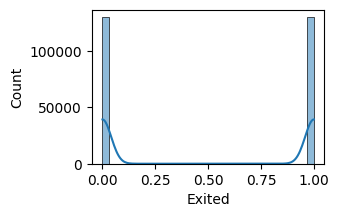

In [ ]:
fig, ax = plt.subplots(figsize=(3, 2))
sns.histplot(y_res_over, kde=True)
plt.show()

In [ ]:
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Bal_Tenure,Bal_Age,Estimsal_Age
0,0.079646,0.0,0.0,-0.4,-0.50,0.000000,0.0,0.0,0.0,0.788698,0.000000,0.000000,0.587500
1,-0.283186,0.0,0.0,-0.4,-1.00,0.000000,0.0,0.0,1.0,-0.850085,0.000000,0.000000,-0.841400
2,0.168142,0.0,0.0,0.3,1.25,0.000000,0.0,0.0,0.0,0.831134,0.000000,0.000000,1.049167
3,-0.690265,0.0,0.0,-0.3,-0.75,1.241313,-1.0,0.0,1.0,-0.414670,0.572559,1.155487,-0.434000
4,0.504425,2.0,0.0,-0.4,0.00,0.000000,0.0,0.0,1.0,-1.277766,0.000000,0.000000,-1.214306


## Train

In [ ]:
y = y_res_over
X = X_res_over
# Припустимо, що X_train та y_train - це ваші тренувальні дані
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((208180, 13), (52046, 13), (208180,), (52046,))

## K-Nearest Neighbors

In [ ]:
# Use StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score


# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# Assuming KNN is your K-Nearest Neighbors model
KNN = KNeighborsClassifier(n_neighbors=5)  # Adjust the number of neighbors as needed

# Use StratifiedKFold for cross-validation with 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and compute ROC AUC scores
KNN_cross_val = cross_val_score(KNN, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1)

# Print the average cross-validated ROC AUC score
print(f"CV score of KNN is {KNN_cross_val.mean()}")
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))


CV score of KNN is 0.884197596194819
2024-01-29 13:12:40


CV score of KNN is 0.8973039285954378
2024-01-29 13:06:09 - n_neibors=5

    KNN_model
    
![image.png](attachment:88506d30-90a6-44ee-b01f-9f2434293e73.png)

##  Histogram Gradient Boosting Classifier

In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score

# Assuming X_train and y_train are your training features and target variables
Hist_GB = HistGradientBoostingClassifier(max_iter=700, learning_rate=0.1, min_samples_leaf=20, max_depth=6, random_state=42)

# Create KFold for cross-validation with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and compute ROC AUC scores
Hist_GB_cross_val = cross_val_score(Hist_GB, X_train, y_train, cv=kf, scoring='roc_auc', n_jobs=-1)

# Print the average cross-validated ROC AUC score
print(f"CV score of Hist GB is {Hist_GB_cross_val.mean()}")
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

CV score of Hist GB is 0.911691476155163
2024-01-29 13:14:03


CV score of Hist GB is 0.9071690559062165
2024-01-29 13:08:04  - max_iter=500, min_samples_leaf=10

## Cat boost

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score

# Assuming X_train and y_train are your training features and target variables
CAT = CatBoostClassifier(iterations=1000, verbose=100, random_seed=42)
CAT.fit(X_train, y_train)

# Assuming X_test and y_test are your testing features and target variables
roc_auc_score = cross_val_score(CAT, X_test, y_test, cv=5, scoring='roc_auc').mean()

print("CV score of CatBoost is:", roc_auc_score)
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

Learning rate set to 0.100672
0:	learn: 0.6353786	total: 176ms	remaining: 2m 55s
100:	learn: 0.4130713	total: 5.26s	remaining: 46.8s
200:	learn: 0.4051554	total: 9.82s	remaining: 39s
300:	learn: 0.3985498	total: 15.7s	remaining: 36.4s
400:	learn: 0.3929645	total: 20.3s	remaining: 30.3s
500:	learn: 0.3877339	total: 26.1s	remaining: 26s
600:	learn: 0.3827227	total: 30.7s	remaining: 20.4s
700:	learn: 0.3780181	total: 35.2s	remaining: 15s
800:	learn: 0.3735661	total: 42.3s	remaining: 10.5s
900:	learn: 0.3693137	total: 48.3s	remaining: 5.3s
999:	learn: 0.3650795	total: 54.2s	remaining: 0us
Learning rate set to 0.050635
0:	learn: 0.6629025	total: 14ms	remaining: 14s
100:	learn: 0.4143483	total: 1.29s	remaining: 11.5s
200:	learn: 0.4049311	total: 2.54s	remaining: 10.1s
300:	learn: 0.3961744	total: 3.77s	remaining: 8.76s
400:	learn: 0.3886410	total: 4.99s	remaining: 7.46s
500:	learn: 0.3817307	total: 6.25s	remaining: 6.22s
600:	learn: 0.3752693	total: 8.45s	remaining: 5.61s
700:	learn: 0.36917

In [ ]:
# from catboost import CatBoostClassifier
# import catboost

# cb_model = CatBoostClassifier(
#     auto_class_weights='Balanced',
#     eval_metric='AUC',
#     learning_rate=0.04,
#     reg_lambda=1,  # L2 regularization
#     depth=7,  # Reduce tree depth
#     verbose=10,
#     random_seed=42,
#     iterations=100
# )

# # Train the model using the specified categorical features
# cb_model.fit(X_train, y_train, eval_set=(X_test, y_test), plot=True)

### Ensemble the models

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score

# KNN, Hist_GB, and CAT are your trained models

# Create a list of tuples where each tuple contains the name of the model and the trained model itself
models = [('KNN', KNN), ('Hist_GB', Hist_GB), ('CAT', CAT)]

# Initialize the VotingClassifier
ensemble_model = VotingClassifier(estimators=models, voting='soft')

# Use cross_val_predict to get the predicted probabilities for each fold
ensemble_preds = cross_val_predict(ensemble_model, X_train, y_train, cv=skf, method='predict_proba')

# Calculate the ROC AUC score for the ensemble
ensemble_roc_auc = roc_auc_score(y_train, ensemble_preds[:, 1])

# Print the ROC AUC score
print(f"ROC AUC score of the ensemble is: {ensemble_roc_auc}")
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))


Learning rate set to 0.091522
0:	learn: 0.6406676	total: 44.1ms	remaining: 44.1s
100:	learn: 0.4125993	total: 3.79s	remaining: 33.7s
200:	learn: 0.4046142	total: 8.8s	remaining: 35s
300:	learn: 0.3978937	total: 13.6s	remaining: 31.5s
400:	learn: 0.3921666	total: 18.1s	remaining: 27.1s
500:	learn: 0.3866844	total: 23.1s	remaining: 23s
600:	learn: 0.3817716	total: 26.8s	remaining: 17.8s
700:	learn: 0.3769264	total: 31.9s	remaining: 13.6s
800:	learn: 0.3725853	total: 35.9s	remaining: 8.91s
900:	learn: 0.3683044	total: 40.1s	remaining: 4.41s
999:	learn: 0.3643515	total: 45.1s	remaining: 0us
Learning rate set to 0.091522
0:	learn: 0.6400037	total: 43.6ms	remaining: 43.6s
100:	learn: 0.4126004	total: 5s	remaining: 44.5s
200:	learn: 0.4048923	total: 8.61s	remaining: 34.2s
300:	learn: 0.3983901	total: 12.2s	remaining: 28.4s
400:	learn: 0.3926807	total: 17.2s	remaining: 25.6s
500:	learn: 0.3874417	total: 20.8s	remaining: 20.7s
600:	learn: 0.3827942	total: 24.5s	remaining: 16.3s
700:	learn: 0.37

ROC AUC score of the ensemble is: 0.9061473216280478
2024-01-29 13:26:14

## Testing

In [ ]:
# Fit the ensemble model on training data
ensemble_model.fit(X_train, y_train)

Learning rate set to 0.100672
0:	learn: 0.6353786	total: 52.7ms	remaining: 52.6s
100:	learn: 0.4130713	total: 8.6s	remaining: 1m 16s
200:	learn: 0.4051554	total: 13.2s	remaining: 52.6s
300:	learn: 0.3985498	total: 20.6s	remaining: 47.7s
400:	learn: 0.3929645	total: 25.2s	remaining: 37.6s
500:	learn: 0.3877339	total: 31s	remaining: 30.9s
600:	learn: 0.3827227	total: 35.6s	remaining: 23.7s
700:	learn: 0.3780181	total: 41.5s	remaining: 17.7s
800:	learn: 0.3735661	total: 46.2s	remaining: 11.5s
900:	learn: 0.3693137	total: 51.1s	remaining: 5.61s
999:	learn: 0.3650795	total: 56.7s	remaining: 0us


VotingClassifier(estimators=[('KNN', KNeighborsClassifier(n_neighbors=50)),
                             ('Hist_GB',
                              HistGradientBoostingClassifier(max_depth=6,
                                                             max_iter=700,
                                                             random_state=42)),
                             ('CAT',
                              <catboost.core.CatBoostClassifier object at 0x7e3ab6f30c70>)],
                 voting='soft')

In [ ]:
# Now, predict probabilities for the test set
df_test_pp = preprocess_data(df_test)

In [ ]:
X_test = df_test_pp
y_pred_proba_test = ensemble_model.predict_proba(X_test)[:, 1]

In [ ]:
uploaded = files.upload()

Saving sample_submission.csv to sample_submission.csv


In [ ]:

# Зчитати файл
sample = pd.read_csv('sample_submission.csv')

# Вивести перші рядки та розмір
print(sample.head())
print(sample.shape)


       id  Exited
0  165034     0.5
1  165035     0.5
2  165036     0.5
3  165037     0.5
4  165038     0.5
(110023, 2)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Assuming y_pred_proba_test is a pandas Series or NumPy array with your predictions
sample['Exited'] = y_pred_proba_test

# Зберегти DataFrame у CSV файл
sample.to_csv('/content/drive/MyDrive/sample_subm_churn_bank_20240129.csv', index=False)
